# 9.5 机器翻译与数据集
- **目录**
  - 9.5.1 下载和预处理数据集
  - 9.5.2 词元化
  - 9.5.3 词表
  - 9.5.4 截断与填充文本序列
  - 9.5.5 加载数据集

语言模型是自然语言处理的关键，
而**机器翻译**是语言模型最成功的基准测试。
因为<b>机器翻译正是将输入序列转换成输出序列的
 序列转换模型（sequence transduction）的核心问题</b>。
序列转换模型在各类现代人工智能应用中发挥着至关重要的作用，
本节将介绍机器翻译问题及其后文需要使用的数据集。

**机器翻译（machine translation）** 指的是
将序列从一种语言自动翻译成另一种语言。
事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代，
特别是在第二次世界大战中使用计算机破解语言编码。
几十年来，在使用神经网络进行端到端学习的兴起之前，
统计学方法在这一领域一直占据主导地位。

因为**统计机器翻译（statistical machine translation）** 涉及了
翻译模型和语言模型等组成部分的统计分析，
因此基于神经网络的方法通常被称为
**神经机器翻译（neural machine translation）**，
用于将两种翻译模型区分开来。

本书的关注点是神经网络机器翻译方法，强调的是**端到端的学习**。
与8.3节中的语料库是单一语言的语言模型问题存在不同，
**机器翻译的数据集是由源语言和目标语言的文本序列对组成的**。
因此，我们需要一种完全不同的方法来预处理机器翻译数据集，
而不是复用语言模型的预处理程序。
下面，我们看一下如何将预处理后的数据加载到小批量中用于训练。

- **要点：**
  - 机器翻译是将一种语言的文本转换成另一种语言，是一种**序列转换**的应用。
  - 机器翻译从20世纪40年代开始发展，最初由**统计学方法**主导。
  - 现代机器翻译多使用神经网络，实现**端对端学习**。
  - 神经机器翻译需要特殊的**数据预处理**，因为它处理成对的**源语言**和**目标语言**数据。
  - 训练时，处理好的数据将用于神经网络模型的**小批量训练**。

---------------------
- **说明：何为端对端学习？**
  - 端对端学习是一种直接从输入数据到**期望输出**的映射方法，它旨在通过学习来自动发现复杂的输入到输出的转换规则。
  - 与传统的方法相比，端对端学习尽可能地减少预定义的处理步骤或规则，而是依赖于一个强大的学习模型（通常是深度神经网络）来**从原始数据中直接学习目标任务**。
  - 端对端学习的关键特性：
    - **最小的预处理和后处理**：端对端学习模型旨在从原始数据到最终任务的决策或输出的直接映射，这意味着尽可能减少数据的预处理（例如特征提取、手动编码）和后处理步骤。
    - **直接目标优化**：端对端学习模型是为了完成特定的任务而训练，例如语音识别中的语音到文本转换，或自动驾驶中的传感器输入到控制命令的转换。整个模型是为了**直接优化**与任务相关的性能指标。
    - **大数据需求**：由于端对端学习需要模型从数据中**自动学习**复杂的规则，因此通常需要大量数据来训练，以确保模型可以学到有效和准确的映射。
    - **强大的模型容量**：端对端学习通常依赖于深度学习或其他高容量模型来捕获**复杂的输入到输出关系**。这些模型有能力从原始数据中提取有用的特征，并学习如何将这些特征转换成所需的输出。
  - 端对端学习的应用示例：
    - **自动驾驶系统**：直接从传感器数据（如摄像头图像）到驾驶命令（如转向角度、加速度）的映射。
    - **机器翻译**：直接从一种语言的句子到另一种语言的句子的转换，而无需手动编写语言规则。
    - **语音识别**：将原始音频波形直接转换为文本。

--------------------------

In [18]:
%matplotlib inline
import os
import torch
from d2l import torch as d2l

## 9.5.1 下载和预处理数据集

- 首先，下载一个由[Tatoeba项目的双语句子对](http://www.manythings.org/anki/)
组成的“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对，
序列对由英文文本序列和翻译后的法语文本序列组成。
- 请注意，每个文本序列可以是一个句子，
也可以是包含多个句子的一个段落。
- 在这个将英语翻译成法语的机器翻译问题中，
英语是**源语言（source language）**，
法语是**目标语言（target language）**。


In [19]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [20]:
import numpy as np
## raw_text就是一个由\t符号即tab键值分割, \n符号换行的字符串
len(raw_text),type(raw_text),raw_text[0:10]

(11489286, str, 'Go.\tVa !\nH')

- 下载数据集后，原始文本数据需要经过几个预处理步骤。
  - 例如，我们用空格代替**不间断空格（non-breaking space）**，
使用小写字母替换大写字母，并在单词和标点符号之间插入空格。


In [21]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    ## 如果字符是非空格符的标点符号，则返回真
    ## 用于后面在标点符号前面插入空格的操作
    def no_space(char, prev_char):
        ## 即字符是逗号句点感叹号问号中的其中一个，而且非空格符，函数返回True
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    ##\u202f与\xa0都是不间断空格，全部替换成' '
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    '''
    即字符串中的第一个字符后面的字符中，如果是空格以外的标点符号，
    则在该标点符号前面加一个空格。
    '''
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


-------------------

- **说明：特殊字符处理以及no_space函数功能**

In [22]:
##join函数可以在字符串字母或字符俩俩之间插入某个字符
'|'.join('hello!')

'h|e|l|l|o|!'

- **特殊字符：**
  - `\u202f`,`\xa0`以及`\u202a`字符都是Unicode编码中的特殊空格字符。
  - `\u202f`：这是NARROW NO-BREAK SPACE，它是一个较窄的不换行空格，用于在两个字符之间添加空格，但不允许换行。
  - `\xa0`：这是NO-BREAK SPACE，它是一个不换行空格，用于在两个字符之间添加空格，但不允许换行。
  - `\u202a`：这是LEFT-TO-RIGHT EMBEDDING，它是Unicode的控制字符之一，用于在文本中指定文本方向，以便在右向左的文本中插入左向右的文本。
  - 这些特殊字符在文本处理中经常用于特定的排版和格式要求，但在一般的文本处理和显示中，这些字符可能会被视为普通的空格字符。

In [23]:
##不间断空格\u202f,\xa0以及\u202a特殊字符
print('ll\u202fll')
print('ll\xa0ll')
print('aa\u202all')

ll ll
ll ll
aa‪ll


In [24]:
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '
t='hello,wo.,!rld!'
##打印结果是在.,!等符号前面都加了一个空格
[' ' + char if i > 0 and no_space(char, t[i - 1]) else char
           for i, char in enumerate(t)]

['h',
 'e',
 'l',
 'l',
 'o',
 ' ,',
 'w',
 'o',
 ' .',
 ' ,',
 ' !',
 'r',
 'l',
 'd',
 ' !']

-----

## 9.5.2 词元化

- 与 8.3节中的字符级词元化不同，
**在机器翻译中，更偏向单词级词元化**
（最先进的模型可能使用更高级的词元化技术）。
- 下面的`tokenize_nmt`函数对前`num_examples`个文本序列对进行词元化，
其中每个词元要么是一个词，要么是一个标点符号。
- 此函数返回两个词元列表：`source`和`target`：
  - `source[i]`是源语言（这里是英语）第$i$个文本序列的词元列表，
  - `target[i]`是目标语言（这里是法语）第$i$个文本序列的词元列表。


In [25]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

In [26]:
## 源和目标的长度是一样的，即有167130对文本
len(source),len(target)

(167130, 167130)

In [27]:
##似乎按照由短到长的顺序保存文本
len(target[-1]),len(source[-1])

(56, 51)

- 首先绘制每个文本序列所包含的词元数量的**直方图**。
- 在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于$20$个。


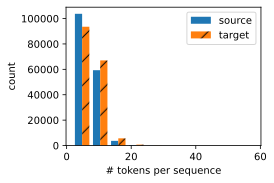

In [28]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

(array([[1.03755e+05, 5.93110e+04, 3.63900e+03, 3.59000e+02, 4.40000e+01,
         1.30000e+01, 6.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00],
        [9.35530e+04, 6.70540e+04, 5.65600e+03, 7.40000e+02, 8.50000e+01,
         3.30000e+01, 2.00000e+00, 2.00000e+00, 2.00000e+00, 3.00000e+00]]),
 array([ 2. ,  7.6, 13.2, 18.8, 24.4, 30. , 35.6, 41.2, 46.8, 52.4, 58. ]),
 <a list of 2 BarContainer objects>)

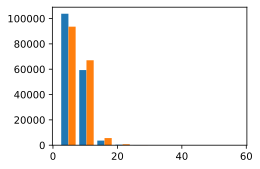

In [29]:
## 细看每个bin的频数
import matplotlib.pyplot as plt
plt.hist([[len(l) for l in source], [len(l) for l in target]])
#plt.show()

## 9.5.3 词表

- 由于机器翻译数据集由语言对组成，
因此我们可以分别为**源语言和目标语言构建两个词表**。
- 使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。
- 为了缓解这一问题，这里我们**将出现次数少于2次的低频率词元视为相同的未知（“&lt;unk&gt;”）词元**。
- 除此之外，我们还指定了额外的特定词元，
  - 在小批量时用于将序列填充到**相同长度**的**填充词元（“&lt;pad&gt;”）**，
  - 序列的**开始词元（“&lt;bos&gt;”）**
  - 序列的**结束词元（“&lt;eos&gt;”）**。
- 这些特殊词元在自然语言处理任务中比较常用。


In [30]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [31]:
src_vocab.idx_to_token[0:10]

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'i', 'you', 'to', 'the', '?']

In [32]:
src_vocab.token_freqs[0:10]

[('.', 139392),
 ('i', 45611),
 ('you', 43192),
 ('to', 36718),
 ('the', 33263),
 ('?', 27619),
 ('a', 23973),
 ('is', 16829),
 ('tom', 13990),
 ('that', 12651)]

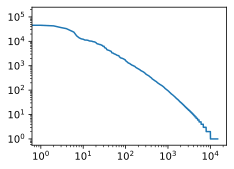

In [33]:
## 词频曲线，最好进行对数伸缩
import matplotlib.pyplot as plt
#plt.style.use('science')
freqs=[]
for _,freq in src_vocab.token_freqs:
    freqs.append(freq)
plt.plot(range(0,len(freqs)),freqs)
plt.xscale('log')
plt.yscale('log')
plt.show()

## 9.5.4 截断与填充文本序列


回想一下，语言模型中的[**序列样本都有一个固定的长度**]，
无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。
这个固定长度是由 8.3节中的
`num_steps`（时间步数或词元数量）参数指定的。
在机器翻译中，每个样本都是由源和目标组成的文本序列对，
其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过**截断（truncation**）和
**填充（padding）** 方式实现一次只处理一个小批量的文本序列。
假设同一个小批量中的每个序列都应该具有相同的长度`num_steps`，
那么如果文本序列的词元数目少于`num_steps`时，
我们将继续在其末尾添加特定的“&lt;pad&gt;”词元，
直到其长度达到`num_steps`；
反之，我们将截断文本序列时，只取其前`num_steps` 个词元，
并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度，
以便以相同形状的小批量进行加载。

如前所述，下面的`truncate_pad`函数将(**截断或填充文本序列**)。

- **要点：**
  - 在机器翻译任务中，每个样本都是由源语言和目标语言的文本序列对组成，每个序列可能具有不同的长度。
  - 为了提高计算效率，在加载数据时，可以通过截断和填充方式使得同一个小批量中的每个序列具有相同的长度`num_steps`。
  - 如果文本序列的词元数目少于`num_steps`，则在其末尾添加特定的“&lt;pad&gt;”词元，直到长度达到`num_steps`。
  - 如果文本序列的词元数目多于`num_steps`，则截断文本序列只保留前`num_steps`个词元，并丢弃剩余的词元。
  - 这样可以确保每个文本序列具有相同的长度，便于以相同形状的小批量进行加载和处理。

In [34]:
#@save
## 填充和截断，保证文本序列的长度统一
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    '''
    《动手学》特别喜欢这种代码风格，虽然没有if...else...
    清晰直接，但是很简洁。当然也容易给初学者造成困扰。
    '''
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [33]:
src_vocab[source[0]], src_vocab['<pad>']

([47, 4], 1)

In [34]:
## list的这种拼接法，很容易让人产生混淆
[3,4,5]+[8]*3

[3, 4, 5, 8, 8, 8]

- 现在定义一个函数，可以将文本序列
**转换成小批量数据集用于训练**。
- **将特定的“&lt;eos&gt;”词元添加到所有序列的末尾，
用于表示序列的结束。**
- 当模型通过一个词元接一个词元地生成序列进行预测时，
**生成的“&lt;eos&gt;”词元说明完成了序列输出工作**。
- 此外，还记录了每个文本序列的长度，
统计长度时排除了填充词元，
在稍后将要介绍的一些模型会需要这个长度信息。


In [35]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    ##在文本序列的后面加上<eos>
    lines = [l + [vocab['<eos>']] for l in lines]
    ##将文本序列进行填充后，转换成torch.tensor
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    ##计算每个文本序列的有效长度，不包括填充字符。
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    ##返回文本序列张量，每个序列的x长度
    return array, valid_len

## 9.5.5 加载数据集

- 最后定义`load_data_nmt`函数来返回数据迭代器，
以及源语言和目标语言的两种词表。


In [36]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

- 读出“英语－法语”数据集中的第一个小批量数据。


In [37]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[16, 51,  4,  3,  1,  1,  1,  1],
        [54,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 3])
Y: tensor([[41, 37, 11,  5,  3,  1,  1,  1],
        [93,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([5, 3])


## 小结

* 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。
* 使用单词级词元化时的词表大小，将明显大于使用字符级词元化时的词表大小。为了缓解这一问题，我们可以将低频词元视为相同的未知词元。
* 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。
